# ICU Vital Sign Forecasting - Exploratory Data Analysis

**Project:** Forecasting ICU Patient Vital-Sign Deterioration Using Hybrid Statistical and Deep Learning Models

**Objective:** Forecast future patient vitals and compare statistical, machine-learning, and deep-learning models

**Target Variables:** HR (bpm), SpO2 (%), BP (mmHg), RR (/min), Temp (°C)

---

## 1. Setup and Configuration

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully")

Libraries imported successfully


In [5]:
# FILE PATHS
BASE_PATH = r"C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4"

PATHS = {
    'CHARTEVENTS': f"{BASE_PATH}\\CHARTEVENTS.csv\\CHARTEVENTS.csv",
    'D_ITEMS': f"{BASE_PATH}\\D_ITEMS.csv\\D_ITEMS.csv",
    'ICUSTAYS': f"{BASE_PATH}\\ICUSTAYS.csv\\ICUSTAYS.csv",
    'PATIENTS': f"{BASE_PATH}\\PATIENTS.csv\\PATIENTS.csv",
    'ADMISSIONS': f"{BASE_PATH}\\ADMISSIONS.csv\\ADMISSIONS.csv"
}

print("File paths configured")
for name, path in PATHS.items():
    print(f"   {name}: {path}")

File paths configured
   CHARTEVENTS: C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\CHARTEVENTS.csv\CHARTEVENTS.csv
   D_ITEMS: C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\D_ITEMS.csv\D_ITEMS.csv
   ICUSTAYS: C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\ICUSTAYS.csv\ICUSTAYS.csv
   PATIENTS: C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\PATIENTS.csv\PATIENTS.csv
   ADMISSIONS: C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\ADMISSIONS.csv\ADMISSIONS.csv


## 2. Load Core Tables (Excluding CHARTEVENTS)

In [6]:
# Load smaller tables first
print("Loading tables...")

d_items = pd.read_csv(PATHS['D_ITEMS'])
print(f"D_ITEMS loaded: {d_items.shape[0]:,} rows")

icustays = pd.read_csv(PATHS['ICUSTAYS'])
print(f"ICUSTAYS loaded: {icustays.shape[0]:,} rows")

patients = pd.read_csv(PATHS['PATIENTS'])
print(f"PATIENTS loaded: {patients.shape[0]:,} rows")

admissions = pd.read_csv(PATHS['ADMISSIONS'])
print(f"ADMISSIONS loaded: {admissions.shape[0]:,} rows")

Loading tables...
D_ITEMS loaded: 12,487 rows
ICUSTAYS loaded: 61,532 rows
PATIENTS loaded: 46,520 rows
ADMISSIONS loaded: 58,976 rows


## 3. Dataset Overview

In [7]:
# Function to display comprehensive overview
def dataset_overview(df, name):
    print("="*60)
    print(f"{name} OVERVIEW")
    print("="*60)
    print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print("\n--- Data Types ---")
    print(df.dtypes.value_counts())
    
    print("\n--- Missing Values ---")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
    print(missing_df[missing_df['Missing'] > 0].sort_values('Percent', ascending=False))
    
    print("\n--- Sample Data ---")
    display(df.head(3))
    return None

In [8]:
dataset_overview(icustays, "ICUSTAYS")

ICUSTAYS OVERVIEW

Shape: 61,532 rows × 12 columns
Memory Usage: 20.84 MB

--- Data Types ---
int64      6
object     5
float64    1
Name: count, dtype: int64

--- Missing Values ---
         Missing  Percent
OUTTIME       10     0.02
LOS           10     0.02

--- Sample Data ---


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.25
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.28
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.89


In [9]:
dataset_overview(patients, "PATIENTS")

PATIENTS OVERVIEW

Shape: 46,520 rows × 8 columns
Memory Usage: 11.90 MB

--- Data Types ---
object    5
int64     3
Name: count, dtype: int64

--- Missing Values ---
          Missing  Percent
DOD_HOSP    36546    78.56
DOD_SSN     33142    71.24
DOD         30761    66.12

--- Sample Data ---


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0


In [10]:
dataset_overview(admissions, "ADMISSIONS")

ADMISSIONS OVERVIEW

Shape: 58,976 rows × 19 columns
Memory Usage: 47.44 MB

--- Data Types ---
object    14
int64      5
Name: count, dtype: int64

--- Missing Values ---
                Missing  Percent
DEATHTIME         53122    90.07
EDOUTTIME         28099    47.64
EDREGTIME         28099    47.64
LANGUAGE          25332    42.95
MARITAL_STATUS    10128    17.17
RELIGION            458     0.78
DIAGNOSIS            25     0.04

--- Sample Data ---


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1


In [11]:
dataset_overview(d_items, "D_ITEMS")

D_ITEMS OVERVIEW

Shape: 12,487 rows × 10 columns
Memory Usage: 4.35 MB

--- Data Types ---
object     7
int64      2
float64    1
Name: count, dtype: int64

--- Missing Values ---
              Missing  Percent
CONCEPTID       12487   100.00
UNITNAME        11636    93.18
PARAM_TYPE       9495    76.04
ABBREVIATION     9495    76.04
CATEGORY         6438    51.56
LABEL               4     0.03

--- Sample Data ---


,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,457,497,Patient controlled analgesia (PCA) [Inject],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1,458,498,PCA Lockout (Min),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2,459,499,PCA Medication,NaN,carevue,chartevents,NaN,NaN,NaN,NaN


## 4. Identify Vital Sign ITEMIDs

In [12]:
# Define vital sign categories and search patterns
vital_patterns = {
    'Heart Rate': ['heart rate', 'hr', 'pulse'],
    'SpO2': ['spo2', 'o2 sat', 'oxygen sat', 'sao2'],
    'Blood Pressure Systolic': ['systolic', 'arterial bp systolic', 'nbp systolic', 'abp systolic'],
    'Blood Pressure Diastolic': ['diastolic', 'arterial bp diastolic', 'nbp diastolic', 'abp diastolic'],
    'Blood Pressure Mean': ['mean', 'arterial bp mean', 'nbp mean', 'abp mean'],
    'Respiratory Rate': ['respiratory rate', 'resp rate', 'rr '],
    'Temperature': ['temperature', 'temp c', 'temp f']
}

# Search for vital signs in D_ITEMS
print("="*60)
print("VITAL SIGN ITEM IDENTIFICATION")
print("="*60)

for vital_name, patterns in vital_patterns.items():
    pattern = '|'.join(patterns)
    matches = d_items[d_items['LABEL'].str.lower().str.contains(pattern, na=False)]
    print(f"\n--- {vital_name} ---")
    if len(matches) > 0:
        print(matches[['ITEMID', 'LABEL', 'DBSOURCE', 'UNITNAME']].head(10).to_string(index=False))
    else:
        print("No matches found")

VITAL SIGN ITEM IDENTIFICATION

--- Heart Rate ---
 ITEMID                   LABEL DBSOURCE UNITNAME
    964              THAM CC/HR  carevue      NaN
   1097     Pantoprazole  mg/hr  carevue      NaN
   1106        Meperidine mg/hr  carevue      NaN
    546 Popliteal Pulse [Right]  carevue      NaN
    549 PostTib. Pulses [Right]  carevue      NaN
    583        Pulses Paradoxus  carevue      NaN
    603    Radial Pulse [Right]  carevue      NaN
    611      Replace Rate ml/hr  carevue      NaN
   1438     Ulnar Pulse [Right]  carevue      NaN
   1456     popliteal pulse r/l  carevue      NaN

--- SpO2 ---
 ITEMID               LABEL DBSOURCE UNITNAME
   3545    O2 Sat W/Seizure  carevue      NaN
    834                SaO2  carevue      NaN
   5501 O2 sat probe change  carevue      NaN
   5505   O2 sat probe site  carevue      NaN
   4833         SaO2 (post)  carevue      NaN
    646                SpO2  carevue      NaN
   3288        O2 sat [Pre]  carevue      NaN
   3495         L

In [13]:
# Defining the specific ITEMIDs for vital signs

VITAL_ITEMIDS = {
    'HR': [211, 220045],                    # Heart Rate (CareVue: 211, MetaVision: 220045)
    'SpO2': [646, 220277],                  # O2 Saturation (CareVue: 646, MetaVision: 220277)
    'SBP': [51, 442, 455, 220179, 220050],  # Systolic BP
    'DBP': [8368, 8440, 8441, 220180, 220051], # Diastolic BP
    'MBP': [456, 52, 6702, 220052, 220181], # Mean BP
    'RR': [618, 615, 220210, 224690],       # Respiratory Rate
    'Temp_C': [223761, 678],                # Temperature Celsius
    'Temp_F': [223762, 679]                 # Temperature Fahrenheit
}

# Flatten all ITEMIDs for filtering
ALL_VITAL_ITEMIDS = [item for sublist in VITAL_ITEMIDS.values() for item in sublist]

print("Selected Vital Sign ITEMIDs:")
for vital, ids in VITAL_ITEMIDS.items():
    print(f"   {vital}: {ids}")

print(f"\n   Total unique ITEMIDs: {len(ALL_VITAL_ITEMIDS)}")

Selected Vital Sign ITEMIDs:
   HR: [211, 220045]
   SpO2: [646, 220277]
   SBP: [51, 442, 455, 220179, 220050]
   DBP: [8368, 8440, 8441, 220180, 220051]
   MBP: [456, 52, 6702, 220052, 220181]
   RR: [618, 615, 220210, 224690]
   Temp_C: [223761, 678]
   Temp_F: [223762, 679]

   Total unique ITEMIDs: 27


## 5. ICU Stays Analysis

In [14]:
# Converting datetime columns
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])

# Calculating LOS in hours (LOS column is in fractional days)
icustays['LOS_hours'] = icustays['LOS'] * 24

print("="*60)
print("ICU STAYS ANALYSIS")
print("="*60)

print(f"\nTotal ICU stays: {len(icustays):,}")
print(f"Unique patients: {icustays['SUBJECT_ID'].nunique():,}")
print(f"Unique hospital admissions: {icustays['HADM_ID'].nunique():,}")

print("\n--- ICU Types ---")
print(icustays['FIRST_CAREUNIT'].value_counts())

print("\n--- Length of Stay (Hours) ---")
print(icustays['LOS_hours'].describe())

ICU STAYS ANALYSIS

Total ICU stays: 61,532
Unique patients: 46,476
Unique hospital admissions: 57,786

--- ICU Types ---
FIRST_CAREUNIT
MICU     21088
CSRU      9312
SICU      8891
NICU      8100
CCU       7726
TSICU     6415
Name: count, dtype: int64

--- Length of Stay (Hours) ---
count   61522.00
mean      118.03
std       231.33
min         0.00
25%        26.59
50%        50.21
75%       107.60
max      4153.74
Name: LOS_hours, dtype: float64


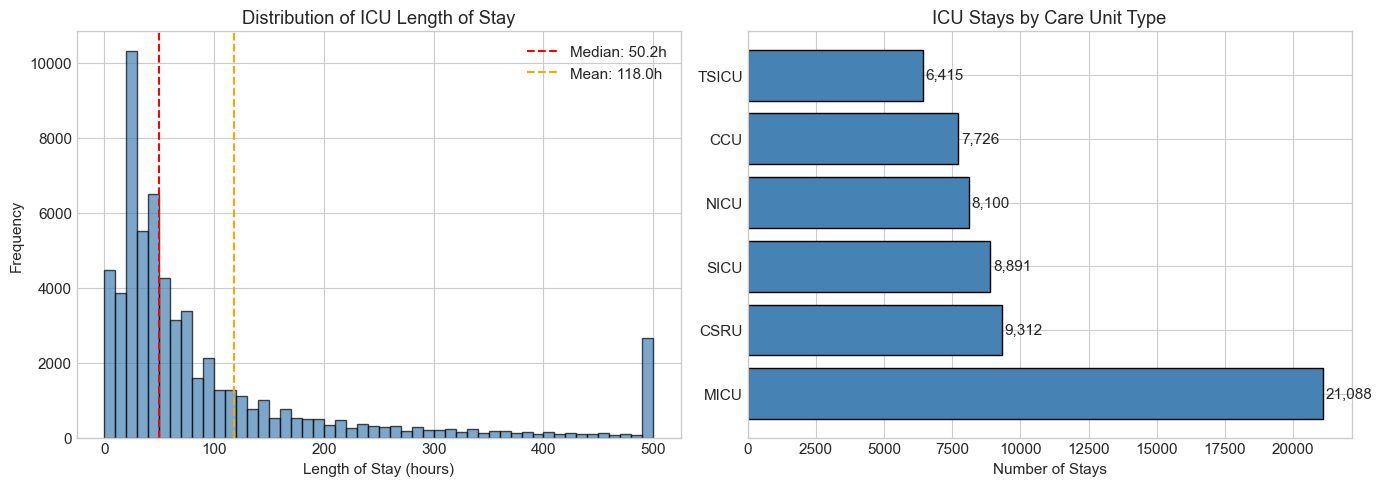

In [15]:
# Visualizing ICU Length of Stay distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of LOS (capped at 500 hours for visualization)
ax1 = axes[0]
los_capped = icustays['LOS_hours'].clip(upper=500)
ax1.hist(los_capped, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(icustays['LOS_hours'].median(), color='red', linestyle='--', label=f'Median: {icustays["LOS_hours"].median():.1f}h')
ax1.axvline(icustays['LOS_hours'].mean(), color='orange', linestyle='--', label=f'Mean: {icustays["LOS_hours"].mean():.1f}h')
ax1.set_xlabel('Length of Stay (hours)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of ICU Length of Stay')
ax1.legend()

# ICU type distribution
ax2 = axes[1]
icu_counts = icustays['FIRST_CAREUNIT'].value_counts()
ax2.barh(icu_counts.index, icu_counts.values, color='steelblue', edgecolor='black')
ax2.set_xlabel('Number of Stays')
ax2.set_title('ICU Stays by Care Unit Type')
for i, v in enumerate(icu_counts.values):
    ax2.text(v + 100, i, f'{v:,}', va='center')

plt.tight_layout()
plt.show()

## 6. Sample Selection for 2,000 ICU Stays

In [16]:
# For the forecasting task, stays must be long enough to have meaningful data

print("="*60)
print("SAMPLE SELECTION ANALYSIS")
print("="*60)

# Analyze stays by different LOS thresholds
thresholds = [6, 12, 24, 48, 72]

print("\nICU stays by minimum Length of Stay:")
print("-" * 40)
for thresh in thresholds:
    count = len(icustays[icustays['LOS_hours'] >= thresh])
    pct = count / len(icustays) * 100
    sufficient = "DONE" if count >= 2000 else "NOT DONE"
    print(f"LOS ≥ {thresh:2d} hours: {count:,} stays ({pct:.1f}%) {sufficient}")

SAMPLE SELECTION ANALYSIS

ICU stays by minimum Length of Stay:
----------------------------------------
LOS ≥  6 hours: 58,059 stays (94.4%) DONE
LOS ≥ 12 hours: 56,720 stays (92.2%) DONE
LOS ≥ 24 hours: 49,214 stays (80.0%) DONE
LOS ≥ 48 hours: 32,313 stays (52.5%) DONE
LOS ≥ 72 hours: 22,669 stays (36.8%) DONE


In [19]:
# Selecting eligible stays
MIN_LOS_HOURS = 24

eligible_stays = icustays[icustays['LOS_hours'] >= MIN_LOS_HOURS].copy()

print(f"\nEligible stays (LOS ≥ {MIN_LOS_HOURS} hours): {len(eligible_stays):,}")
print(f"2,000 stays needed: {'SUFFICIENT' if len(eligible_stays) >= 2000 else 'NOT ENOUGH'}")


Eligible stays (LOS ≥ 24 hours): 49,214
2,000 stays needed: SUFFICIENT


In [20]:
# Random sample of 2,000 ICU stays for analysis
np.random.seed(42)  # For reproducibility

SAMPLE_SIZE = 2000

if len(eligible_stays) >= SAMPLE_SIZE:
    sample_stays = eligible_stays.sample(n=SAMPLE_SIZE, random_state=42)
    print(f"Successfully sampled {SAMPLE_SIZE:,} ICU stays")
else:
    sample_stays = eligible_stays.copy()
    print(f"Only {len(eligible_stays):,} eligible stays available")

# Save the ICU_STAYIDs for filtering CHARTEVENTS
SAMPLE_ICUSTAY_IDS = sample_stays['ICUSTAY_ID'].tolist()

print(f"\n--- Sample Statistics ---")
print(sample_stays[['LOS_hours', 'LOS']].describe())

Successfully sampled 2,000 ICU stays

--- Sample Statistics ---
       LOS_hours     LOS
count    2000.00 2000.00
mean      159.12    6.63
std       299.09   12.46
min        24.02    1.00
25%        41.59    1.73
50%        67.45    2.81
75%       143.77    5.99
max      3619.18  150.80


## 7. Mortality and Deterioration Analysis

In [21]:
# Merge ICU stays with admission outcomes
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'])
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])

icu_outcomes = sample_stays.merge(
    admissions[['HADM_ID', 'HOSPITAL_EXPIRE_FLAG', 'DEATHTIME', 'ADMISSION_TYPE']], 
    on='HADM_ID',
    how='left'
)

# Merge with patient data
patients['DOD'] = pd.to_datetime(patients['DOD'])
icu_outcomes = icu_outcomes.merge(
    patients[['SUBJECT_ID', 'GENDER', 'DOD']], 
    on='SUBJECT_ID',
    how='left'
)

print("="*60)
print("MORTALITY / DETERIORATION ANALYSIS (Sample)")
print("="*60)

print(f"\nSample size: {len(icu_outcomes):,} ICU stays")
print(f"Hospital mortality in sample: {icu_outcomes['HOSPITAL_EXPIRE_FLAG'].sum():,} ({icu_outcomes['HOSPITAL_EXPIRE_FLAG'].mean()*100:.2f}%)")

MORTALITY / DETERIORATION ANALYSIS (Sample)

Sample size: 2,000 ICU stays
Hospital mortality in sample: 227 (11.35%)


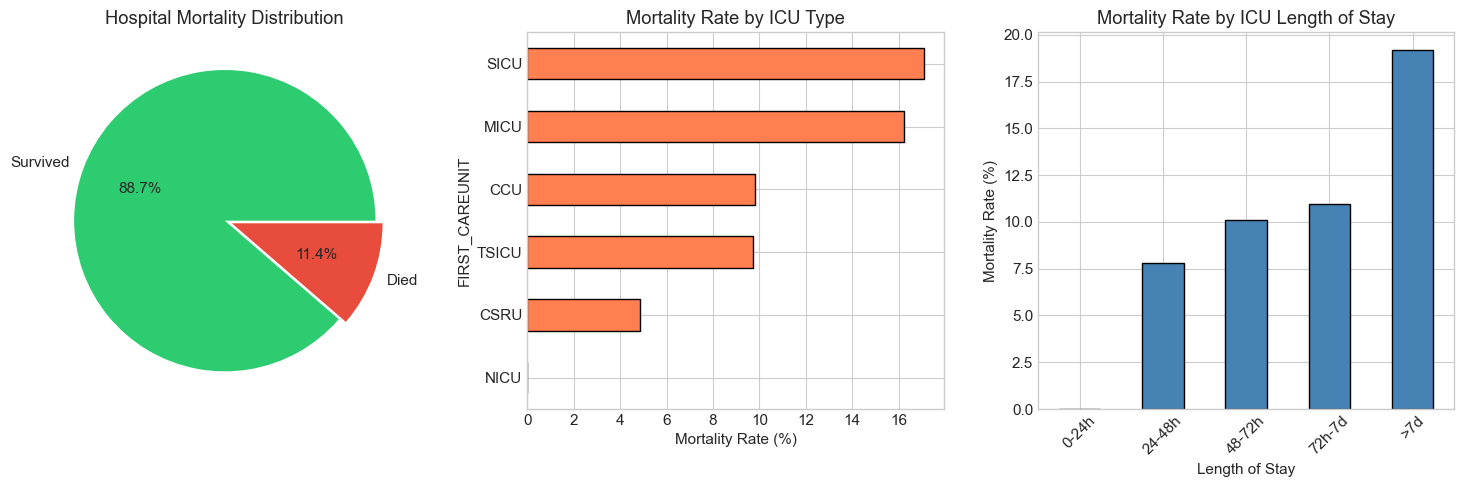

In [22]:
# Visualizing mortality
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mortality distribution
ax1 = axes[0]
mortality_counts = icu_outcomes['HOSPITAL_EXPIRE_FLAG'].value_counts()
colors = ['#2ecc71', '#e74c3c']
ax1.pie(mortality_counts, labels=['Survived', 'Died'], autopct='%1.1f%%', colors=colors, explode=(0, 0.05))
ax1.set_title('Hospital Mortality Distribution')

# Mortality by ICU type
ax2 = axes[1]
mortality_by_icu = icu_outcomes.groupby('FIRST_CAREUNIT')['HOSPITAL_EXPIRE_FLAG'].mean() * 100
mortality_by_icu.sort_values(ascending=True).plot(kind='barh', ax=ax2, color='coral', edgecolor='black')
ax2.set_xlabel('Mortality Rate (%)')
ax2.set_title('Mortality Rate by ICU Type')

# Mortality by LOS
ax3 = axes[2]
icu_outcomes['LOS_bin'] = pd.cut(icu_outcomes['LOS_hours'], bins=[0, 24, 48, 72, 168, 1000], 
                                  labels=['0-24h', '24-48h', '48-72h', '72h-7d', '>7d'])
mortality_by_los = icu_outcomes.groupby('LOS_bin')['HOSPITAL_EXPIRE_FLAG'].mean() * 100
mortality_by_los.plot(kind='bar', ax=ax3, color='steelblue', edgecolor='black')
ax3.set_xlabel('Length of Stay')
ax3.set_ylabel('Mortality Rate (%)')
ax3.set_title('Mortality Rate by ICU Length of Stay')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Load CHARTEVENTS (Vital Signs Only)

In [23]:
print("="*60)
print("LOADING CHARTEVENTS (Vital Signs Only)")
print("="*60)
print("\nThis may take 10-30 minutes for the full file...")
print(f"   Filtering for {len(ALL_VITAL_ITEMIDS)} ITEMIDs")
print(f"   Filtering for {len(SAMPLE_ICUSTAY_IDS):,} ICU stays")

# Convert to set for faster lookup
sample_icustay_set = set(SAMPLE_ICUSTAY_IDS)
vital_itemid_set = set(ALL_VITAL_ITEMIDS)

# Process in chunks
CHUNK_SIZE = 1_000_000
vitals_list = []
chunk_count = 0

try:
    for chunk in pd.read_csv(PATHS['CHARTEVENTS'], chunksize=CHUNK_SIZE, low_memory=False):
        chunk_count += 1
        
        # Filter for vital ITEMIDs and sample ICU stays
        filtered = chunk[
            (chunk['ITEMID'].isin(vital_itemid_set)) & 
            (chunk['ICUSTAY_ID'].isin(sample_icustay_set))
        ]
        
        if len(filtered) > 0:
            vitals_list.append(filtered)
        
        if chunk_count % 50 == 0:
            rows_collected = sum(len(df) for df in vitals_list)
            print(f"   Processed {chunk_count} chunks ({chunk_count * CHUNK_SIZE / 1e6:.0f}M rows), collected {rows_collected:,} vital records")

    # Combine all filtered chunks
    vitals_df = pd.concat(vitals_list, ignore_index=True)
    print(f"\nCHARTEVENTS loaded successfully!")
    print(f"   Total vital sign records: {len(vitals_df):,}")
    
except Exception as e:
    print(f"Error loading CHARTEVENTS: {e}")
    print("\nAlternative: If file is too large, consider:")
    print("   1. Loading a subset of patients first")
    print("   2. Using a database like PostgreSQL")
    print("   3. Pre-filtering with command-line tools (grep, awk)")

LOADING CHARTEVENTS (Vital Signs Only)

This may take 10-30 minutes for the full file...
   Filtering for 27 ITEMIDs
   Filtering for 2,000 ICU stays
   Processed 50 chunks (50M rows), collected 646,999 vital records
   Processed 100 chunks (100M rows), collected 921,316 vital records
   Processed 150 chunks (150M rows), collected 1,155,356 vital records
   Processed 200 chunks (200M rows), collected 1,382,806 vital records
   Processed 250 chunks (250M rows), collected 1,638,555 vital records
   Processed 300 chunks (300M rows), collected 1,663,885 vital records

CHARTEVENTS loaded successfully!
   Total vital sign records: 1,663,885


In [24]:
# Save extracted vitals
BASE_PATH = r"C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4"
VITALS_SAVE_PATH = f"{BASE_PATH}\\vitals_sample_2000.csv"

vitals_df.to_csv(VITALS_SAVE_PATH, index=False)
print(f" Vitals saved to: {VITALS_SAVE_PATH}")

vitals_df = pd.read_csv(VITALS_SAVE_PATH)
print(f" Vitals loaded from: {VITALS_SAVE_PATH}")

 Vitals saved to: C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\vitals_sample_2000.csv
 Vitals loaded from: C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\vitals_sample_2000.csv


## 9. Vital Signs Exploratory Analysis

In [25]:
# Overview of extracted vitals
print("="*60)
print("VITAL SIGNS DATA OVERVIEW")
print("="*60)

vitals_df['CHARTTIME'] = pd.to_datetime(vitals_df['CHARTTIME'])

print(f"\nTotal records: {len(vitals_df):,}")
print(f"Unique ICU stays: {vitals_df['ICUSTAY_ID'].nunique():,}")
print(f"Unique patients: {vitals_df['SUBJECT_ID'].nunique():,}")
print(f"Date range: {vitals_df['CHARTTIME'].min()} to {vitals_df['CHARTTIME'].max()}")

print("\n--- Records by Vital Type (ITEMID) ---")
# Merge with D_ITEMS to get labels
vitals_counts = vitals_df.merge(d_items[['ITEMID', 'LABEL']], on='ITEMID', how='left')
print(vitals_counts.groupby(['ITEMID', 'LABEL']).size().sort_values(ascending=False).head(15))

VITAL SIGNS DATA OVERVIEW

Total records: 1,663,885
Unique ICU stays: 1,977
Unique patients: 1,939
Date range: 2100-08-08 08:30:00 to 2205-10-15 22:00:00

--- Records by Vital Type (ITEMID) ---
ITEMID  LABEL                                
211     Heart Rate                               241014
646     SpO2                                     150232
618     Respiratory Rate                         147469
51      Arterial BP [Systolic]                    96250
8368    Arterial BP [Diastolic]                   95840
52      Arterial BP Mean                          95123
220045  Heart Rate                                94671
220210  Respiratory Rate                          94162
220277  O2 saturation pulseoxymetry               91597
455     NBP [Systolic]                            64384
8441    NBP [Diastolic]                           64079
456     NBP Mean                                  63362
220181  Non Invasive Blood Pressure mean          49132
220179  Non Invasive Blood Press

In [26]:
# Map ITEMIDs to standardized vital names
def map_vital_name(itemid):
    for vital_name, itemids in VITAL_ITEMIDS.items():
        if itemid in itemids:
            return vital_name
    return 'Other'

vitals_df['VITAL_TYPE'] = vitals_df['ITEMID'].apply(map_vital_name)

print("\n--- Records by Standardized Vital Type ---")
print(vitals_df['VITAL_TYPE'].value_counts())


--- Records by Standardized Vital Type ---
VITAL_TYPE
HR        335685
RR        268656
SBP       248313
DBP       247554
MBP       247252
SpO2      241829
Temp_C     53495
Temp_F     21101
Name: count, dtype: int64


In [28]:
# Statistical summary of vital values
print("="*60)
print("VITAL SIGNS STATISTICAL SUMMARY")
print("="*60)

# Convert VALUENUM to numeric
vitals_df['VALUENUM'] = pd.to_numeric(vitals_df['VALUENUM'], errors='coerce')

vital_stats = vitals_df.groupby('VITAL_TYPE')['VALUENUM'].describe()
print(vital_stats)

VITAL SIGNS STATISTICAL SUMMARY
               count   mean    std    min    25%    50%    75%       max
VITAL_TYPE                                                              
DBP        247554.00  60.59 188.25   0.00  50.00  58.00  68.00  78114.00
HR         335623.00 105.27  34.75   0.00  79.00  94.00 134.00    770.00
MBP        246700.00  79.26  23.06 -36.00  67.67  77.00  89.00   7157.00
RR         268447.00  20.35   7.96   0.00  16.00  20.00  24.00   2052.00
SBP        247681.00 122.72 284.49   0.00 105.00 120.00 138.00 141146.04
SpO2       241729.00  97.10   3.52   0.00  96.00  98.00  99.00    100.00
Temp_C      53370.00  98.58   2.53   0.00  97.60  98.60  99.60    105.70
Temp_F      20960.00  87.91  23.79   0.00  97.16  98.78  99.68    105.44


In [29]:
# Define physiologically plausible ranges for cleaning
VITAL_RANGES = {
    'HR': (20, 300),           # Heart Rate: 20-300 bpm
    'SpO2': (50, 100),         # O2 Sat: 50-100%
    'SBP': (40, 300),          # Systolic BP: 40-300 mmHg
    'DBP': (20, 200),          # Diastolic BP: 20-200 mmHg
    'MBP': (30, 250),          # Mean BP: 30-250 mmHg
    'RR': (4, 60),             # Respiratory Rate: 4-60 /min
    'Temp_C': (30, 45),        # Temperature: 30-45°C
    'Temp_F': (86, 113)        # Temperature: 86-113°F
}

print("\n--- Outlier Analysis (Values Outside Plausible Range) ---")
for vital, (low, high) in VITAL_RANGES.items():
    vital_data = vitals_df[vitals_df['VITAL_TYPE'] == vital]['VALUENUM']
    outliers = vital_data[(vital_data < low) | (vital_data > high)]
    outlier_pct = len(outliers) / len(vital_data) * 100 if len(vital_data) > 0 else 0
    print(f"{vital:8s}: {len(outliers):,} outliers ({outlier_pct:.2f}%) outside [{low}, {high}]")


--- Outlier Analysis (Values Outside Plausible Range) ---
HR      : 91 outliers (0.03%) outside [20, 300]
SpO2    : 153 outliers (0.06%) outside [50, 100]
SBP     : 578 outliers (0.23%) outside [40, 300]
DBP     : 665 outliers (0.27%) outside [20, 200]
MBP     : 653 outliers (0.26%) outside [30, 250]
RR      : 1,486 outliers (0.55%) outside [4, 60]
Temp_C  : 53,359 outliers (99.75%) outside [30, 45]
Temp_F  : 3,767 outliers (17.85%) outside [86, 113]


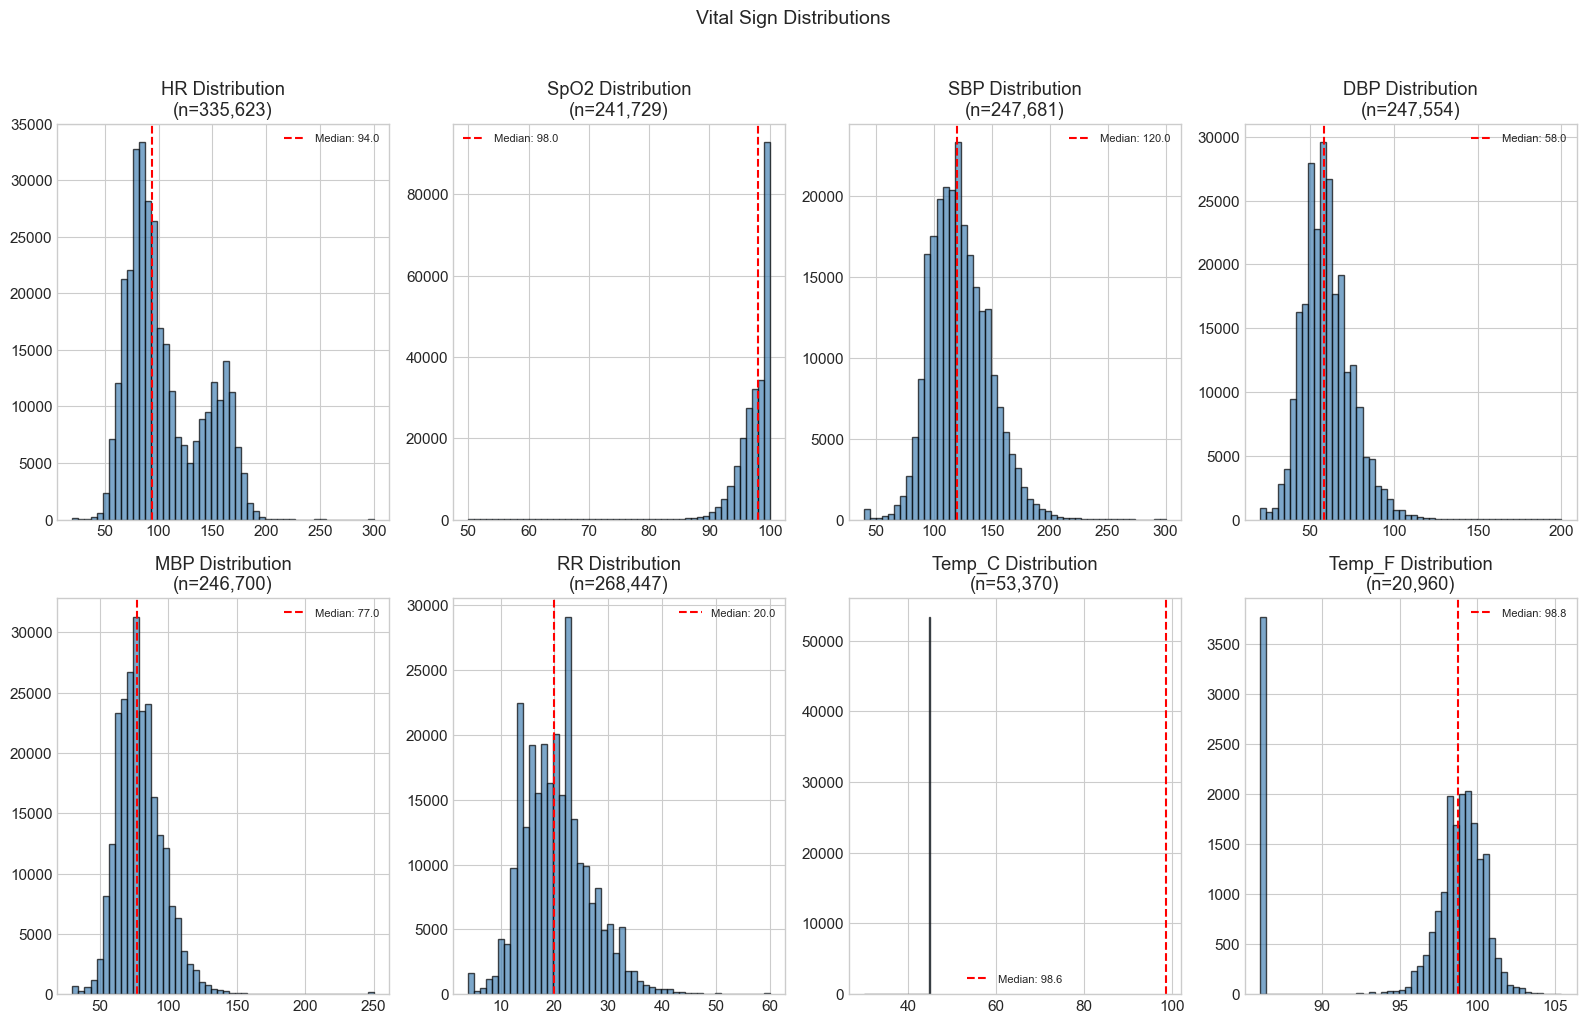

In [30]:
# Visualizing vital sign distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

vitals_to_plot = ['HR', 'SpO2', 'SBP', 'DBP', 'MBP', 'RR', 'Temp_C', 'Temp_F']

for i, vital in enumerate(vitals_to_plot):
    ax = axes[i]
    vital_data = vitals_df[vitals_df['VITAL_TYPE'] == vital]['VALUENUM'].dropna()
    
    if len(vital_data) > 0:
        low, high = VITAL_RANGES.get(vital, (vital_data.quantile(0.01), vital_data.quantile(0.99)))
        vital_clipped = vital_data.clip(lower=low, upper=high)
        
        ax.hist(vital_clipped, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        ax.axvline(vital_data.median(), color='red', linestyle='--', label=f'Median: {vital_data.median():.1f}')
        ax.set_title(f'{vital} Distribution\n(n={len(vital_data):,})')
        ax.legend(fontsize=8)
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{vital} - No Data')

plt.suptitle('Vital Sign Distributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 10. Temporal Analysis

In [31]:
# Analyze measurement frequency
print("="*60)
print("TEMPORAL ANALYSIS")
print("="*60)

# Calculate time between measurements for each patient
vitals_sorted = vitals_df.sort_values(['ICUSTAY_ID', 'VITAL_TYPE', 'CHARTTIME'])
vitals_sorted['TIME_DIFF'] = vitals_sorted.groupby(['ICUSTAY_ID', 'VITAL_TYPE'])['CHARTTIME'].diff()
vitals_sorted['TIME_DIFF_MINS'] = vitals_sorted['TIME_DIFF'].dt.total_seconds() / 60

print("\n--- Average Time Between Measurements (minutes) ---")
time_between = vitals_sorted.groupby('VITAL_TYPE')['TIME_DIFF_MINS'].describe()
print(time_between[['mean', '50%', 'min', 'max']])

TEMPORAL ANALYSIS

--- Average Time Between Measurements (minutes) ---
             mean    50%  min      max
VITAL_TYPE                            
DBP         51.14  60.00 0.00 35520.00
HR          55.02  60.00 0.00 33780.00
MBP         51.15  60.00 0.00 33780.00
RR          47.18  60.00 0.00 33780.00
SBP         50.99  60.00 0.00 35520.00
SpO2        52.26  60.00 0.00 33780.00
Temp_C     228.39 240.00 1.00 33900.00
Temp_F      61.97  60.00 1.00 49233.00


In [32]:
# Measurements per ICU stay
measurements_per_stay = vitals_df.groupby(['ICUSTAY_ID', 'VITAL_TYPE']).size().unstack(fill_value=0)

print("\n--- Measurements Per ICU Stay ---")
print(measurements_per_stay.describe())


--- Measurements Per ICU Stay ---
VITAL_TYPE     DBP      HR     MBP      RR     SBP    SpO2  Temp_C  Temp_F
count      1977.00 1977.00 1977.00 1977.00 1977.00 1977.00 1977.00 1977.00
mean        125.22  169.80  125.06  135.89  125.60  122.32   27.06   10.67
std         204.60  348.21  204.97  285.82  205.06  239.29   43.27   50.97
min           0.00    1.00    0.00    0.00    0.00    0.00    0.00    0.00
25%          35.00   43.00   35.00   36.00   35.00   35.00    7.00    0.00
50%          62.00   72.00   62.00   64.00   63.00   59.00   14.00    0.00
75%         127.00  154.00  126.00  126.00  127.00  119.00   28.00    0.00
max        3459.00 6724.00 3514.00 6713.00 3459.00 6156.00  552.00 1495.00


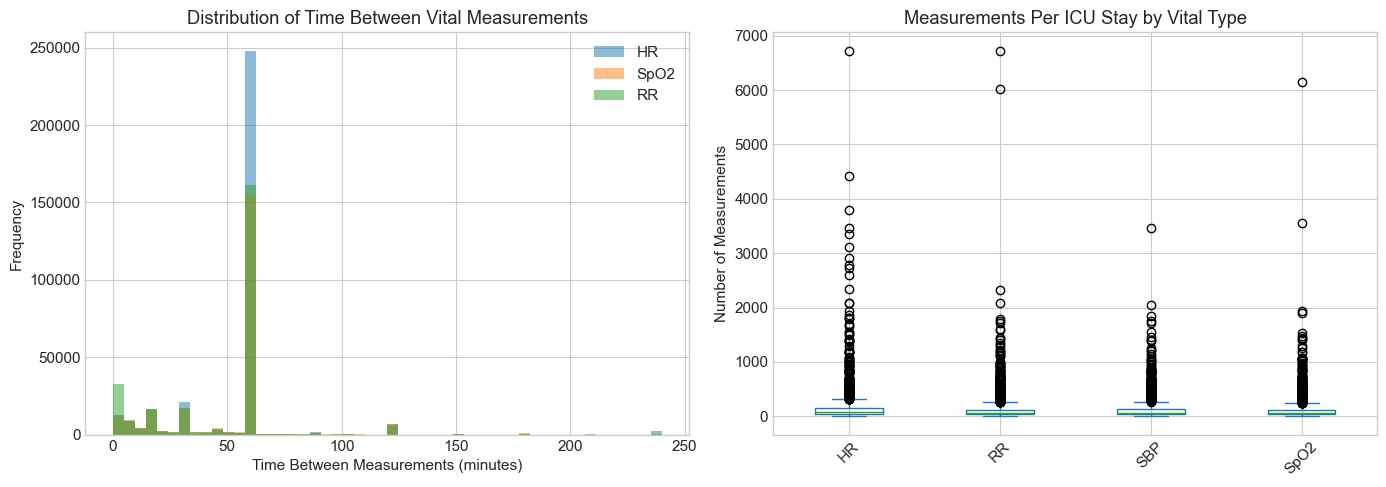

In [33]:
# Visualizing measurement frequency
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time between measurements distribution
ax1 = axes[0]
for vital in ['HR', 'SpO2', 'RR']:
    vital_times = vitals_sorted[vitals_sorted['VITAL_TYPE'] == vital]['TIME_DIFF_MINS'].dropna()
    vital_times_clipped = vital_times[vital_times <= 240]  # Cap at 4 hours
    if len(vital_times_clipped) > 0:
        ax1.hist(vital_times_clipped, bins=50, alpha=0.5, label=vital)
ax1.set_xlabel('Time Between Measurements (minutes)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Time Between Vital Measurements')
ax1.legend()

# Measurements per stay boxplot
ax2 = axes[1]
cols_to_plot = [col for col in measurements_per_stay.columns if col in ['HR', 'SpO2', 'SBP', 'RR']]
if cols_to_plot:
    measurements_per_stay[cols_to_plot].plot(kind='box', ax=ax2)
    ax2.set_ylabel('Number of Measurements')
    ax2.set_title('Measurements Per ICU Stay by Vital Type')
    ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 11. Missingness Analysis

In [34]:
print("="*60)
print("MISSINGNESS ANALYSIS")
print("="*60)

# Check which vitals are available for each ICU stay
vital_availability = vitals_df.groupby('ICUSTAY_ID')['VITAL_TYPE'].apply(lambda x: set(x))

required_vitals = {'HR', 'SpO2', 'SBP', 'RR'}

# Count stays with all required vitals
stays_with_all = sum(1 for v in vital_availability if required_vitals.issubset(v))
print(f"\nICU stays with all required vitals (HR, SpO2, SBP, RR): {stays_with_all:,} ({stays_with_all/len(vital_availability)*100:.1f}%)")

# Availability by vital type
print("\n--- Vital Availability Across ICU Stays ---")
for vital in ['HR', 'SpO2', 'SBP', 'DBP', 'MBP', 'RR', 'Temp_C', 'Temp_F']:
    count = sum(1 for v in vital_availability if vital in v)
    pct = count / len(vital_availability) * 100
    print(f"{vital:8s}: {count:,} stays ({pct:.1f}%)")

MISSINGNESS ANALYSIS

ICU stays with all required vitals (HR, SpO2, SBP, RR): 1,806 (91.4%)

--- Vital Availability Across ICU Stays ---
HR      : 1,977 stays (100.0%)
SpO2    : 1,807 stays (91.4%)
SBP     : 1,806 stays (91.4%)
DBP     : 1,806 stays (91.4%)
MBP     : 1,806 stays (91.4%)
RR      : 1,808 stays (91.5%)
Temp_C  : 1,776 stays (89.8%)
Temp_F  : 335 stays (16.9%)


In [45]:
pip install upsetplot

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24914 sha256=0c445e6c3d5af22a3517b3f72fe709ff5474defbf78066de49bcbe28eab2b34d
  Stored in directory: c:\users\hasin\appdata\local\pip\cache\wheels\25\f7\e8\cf1a20f6721631b3607d04dfd5c31889cf5a512177fa2a0564
Successfully built upsetplot
Note: you may need to restart the kernel to use updated packages.


ADVANCED MISSINGNESS ANALYSIS
Analyzing missingness for: ['SBP', 'DBP', 'SpO2', 'RR', 'HR', 'Temp_C']

Total observations: 362,144

Missingness rates:
VITAL_TYPE
Temperature   100.00
SBP            35.50
DBP            35.50
SpO2           33.30
RR             31.40
HR              7.40
dtype: float64


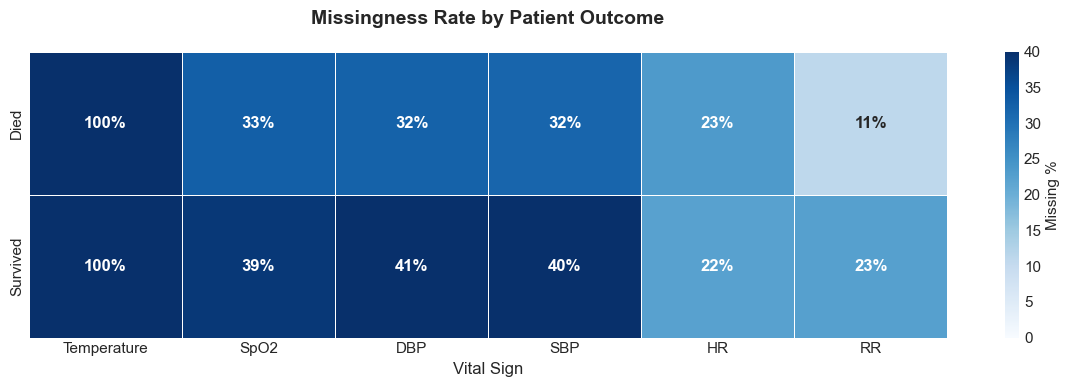


Missingness by outcome heatmap saved to 'missingness_by_outcome.png'

Table: Missingness Rate (%) by Outcome
------------------------------------------------------------
Vital Sign  Temperature  SpO2   DBP   SBP    HR    RR
Outcome                                              
Died             100.00 32.70 32.30 31.90 23.50 11.10
Survived          99.90 38.70 40.60 40.40 22.30 22.60

--- Statistical Comparison (Chi-square test) ---
SBP                 : χ² =     5.81, p = 0.0159 *
DBP                 : χ² =     5.43, p = 0.0198 *
SpO2                : χ² =     2.73, p = 0.0983 
RR                  : χ² =    15.26, p = 0.0001 ***
HR                  : χ² =     0.09, p = 0.7677 
Temperature         : χ² =     0.00, p = 1.0000 

--- Overall Missingness Rates ---
Temperature   100.00
SBP            35.50
DBP            35.50
SpO2           33.30
RR             31.40
HR              7.40


In [53]:
from matplotlib.gridspec import GridSpec
print("=" * 60)
print("ADVANCED MISSINGNESS ANALYSIS")
print("=" * 60)

# Create a binary missingness matrix for each observation
# Using vitals_pivot which has vitals as columns

vitals_to_analyze = ['SBP', 'DBP', 'SpO2', 'Respiratory Rate', 'Pulse', 'Temperature', 'Consciousness']

# Mapping column names to match
column_mapping = {
    'SBP': 'SBP',
    'DBP': 'DBP', 
    'SpO2': 'SpO2',
    'RR': 'RR',
    'HR': 'HR',
    'Temperature': 'Temp_C',
}

# Get available columns
available_cols = [col for col in column_mapping.values() if col in vitals_pivot.columns]
print(f"Analyzing missingness for: {available_cols}")

# Create missingness indicator (1 = missing, 0 = present)
missing_matrix = vitals_pivot[available_cols].isnull().astype(int)

# Rename columns for better display
rename_dict = {v: k for k, v in column_mapping.items() if v in available_cols}
missing_matrix = missing_matrix.rename(columns=rename_dict)

print(f"\nTotal observations: {len(missing_matrix):,}")
print(f"\nMissingness rates:")
print((missing_matrix.mean() * 100).round(1).sort_values(ascending=False))


# Missingness by Outcome (Died vs Survived)
# Merge with outcome data
# First, get ICUSTAY_ID back into missing_matrix
missing_with_id = vitals_pivot[['ICUSTAY_ID'] + available_cols].copy()
missing_with_id = missing_with_id.drop_duplicates(subset=['ICUSTAY_ID'])

# Merge with mortality outcome (from icu_outcomes)
if 'icu_outcomes' in dir() and 'HOSPITAL_EXPIRE_FLAG' in icu_outcomes.columns:
    outcome_df = icu_outcomes[['ICUSTAY_ID', 'HOSPITAL_EXPIRE_FLAG']].drop_duplicates()
    missing_with_outcome = missing_with_id.merge(outcome_df, on='ICUSTAY_ID', how='left')
    
    # Create outcome labels
    missing_with_outcome['Outcome'] = missing_with_outcome['HOSPITAL_EXPIRE_FLAG'].map({1: 'Died', 0: 'Survived'})
    missing_with_outcome = missing_with_outcome.dropna(subset=['Outcome'])
    
    # Calculate missingness rate by outcome for each vital
    missingness_by_outcome = []
    
    for vital in available_cols:
        for outcome in ['Died', 'Survived']:
            subset = missing_with_outcome[missing_with_outcome['Outcome'] == outcome]
            missing_rate = subset[vital].isnull().mean() * 100
            missingness_by_outcome.append({
                'Vital Sign': rename_dict.get(vital, vital),
                'Outcome': outcome,
                'Missing %': missing_rate
            })
    
    missingness_outcome_df = pd.DataFrame(missingness_by_outcome)
    
    # Pivot for heatmap
    heatmap_data = missingness_outcome_df.pivot(index='Outcome', columns='Vital Sign', values='Missing %')
    
    # Reorder columns by overall missingness
    col_order = heatmap_data.loc['Died'].sort_values(ascending=False).index
    heatmap_data = heatmap_data[col_order]
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 4))
    
    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='Blues', 
                linewidths=0.5, ax=ax, vmin=0, vmax=40,
                annot_kws={'size': 12, 'weight': 'bold'},
                cbar_kws={'label': 'Missing %'})
    
    # Add % symbol to annotations
    for t in ax.texts:
        t.set_text(t.get_text() + '%')
    
    ax.set_xlabel('Vital Sign', fontsize=12)
    ax.set_ylabel('')
    ax.set_title('Missingness Rate by Patient Outcome', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig('missingness_by_outcome.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nMissingness by outcome heatmap saved to 'missingness_by_outcome.png'")
    
    # Print summary table
    print("\nTable: Missingness Rate (%) by Outcome")
    print("-" * 60)
    print(heatmap_data.round(1).to_string())
    
    # Statistical test for difference
    print("\n--- Statistical Comparison (Chi-square test) ---")
    from scipy.stats import chi2_contingency
    
    for vital in available_cols:
        vital_name = rename_dict.get(vital, vital)
        died = missing_with_outcome[missing_with_outcome['Outcome'] == 'Died'][vital]
        survived = missing_with_outcome[missing_with_outcome['Outcome'] == 'Survived'][vital]
        
        # Create contingency table
        table = pd.crosstab(
            missing_with_outcome['Outcome'],
            missing_with_outcome[vital].isnull()
        )
        
        if table.shape == (2, 2):
            chi2, p, dof, expected = chi2_contingency(table)
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            print(f"{vital_name:20s}: χ² = {chi2:8.2f}, p = {p:.4f} {sig}")

else:
    print("icu_outcomes not found. Creating missingness heatmap without outcome stratification.")

print("\n--- Overall Missingness Rates ---")
overall_missing = (vitals_pivot[available_cols].isnull().mean() * 100).round(1)
overall_missing.index = [rename_dict.get(col, col) for col in overall_missing.index]
print(overall_missing.sort_values(ascending=False).to_string())

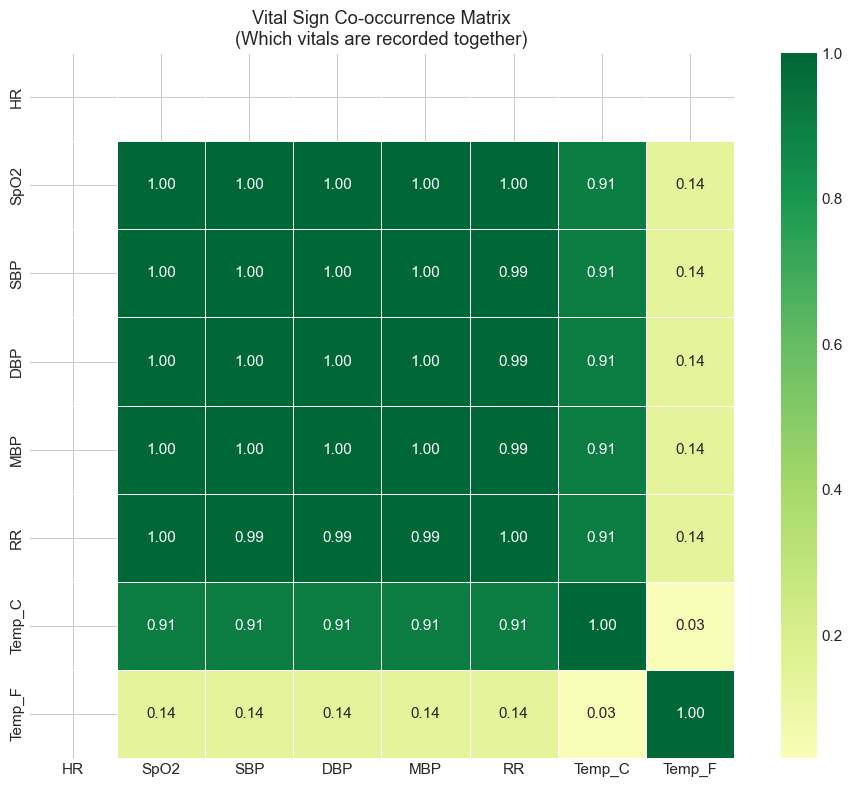

In [35]:
# Visualize missingness pattern
vital_cols = ['HR', 'SpO2', 'SBP', 'DBP', 'MBP', 'RR', 'Temp_C', 'Temp_F']
availability_matrix = pd.DataFrame(index=vital_availability.index)

for vital in vital_cols:
    availability_matrix[vital] = vital_availability.apply(lambda x: 1 if vital in x else 0)

# Correlation of availability (which vitals tend to be present together)
plt.figure(figsize=(10, 8))
sns.heatmap(availability_matrix.corr(), annot=True, cmap='RdYlGn', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Vital Sign Co-occurrence Matrix\n(Which vitals are recorded together)')
plt.tight_layout()
plt.show()

## 12. Correlation Analysis Between Vitals

In [36]:
# Creating a wide-format dataset for correlation analysis
# Aggregating to hourly means for each patient

print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Clean vitals (remove outliers)
vitals_clean = vitals_df.copy()
for vital, (low, high) in VITAL_RANGES.items():
    mask = (vitals_clean['VITAL_TYPE'] == vital) & \
           ((vitals_clean['VALUENUM'] < low) | (vitals_clean['VALUENUM'] > high))
    vitals_clean.loc[mask, 'VALUENUM'] = np.nan

# Pivot to get vitals as columns
vitals_pivot = vitals_clean.pivot_table(
    index=['ICUSTAY_ID', 'CHARTTIME'],
    columns='VITAL_TYPE',
    values='VALUENUM',
    aggfunc='mean'
).reset_index()

print(f"\nPivoted dataset: {vitals_pivot.shape[0]:,} rows × {vitals_pivot.shape[1]} columns")

CORRELATION ANALYSIS

Pivoted dataset: 362,144 rows × 10 columns


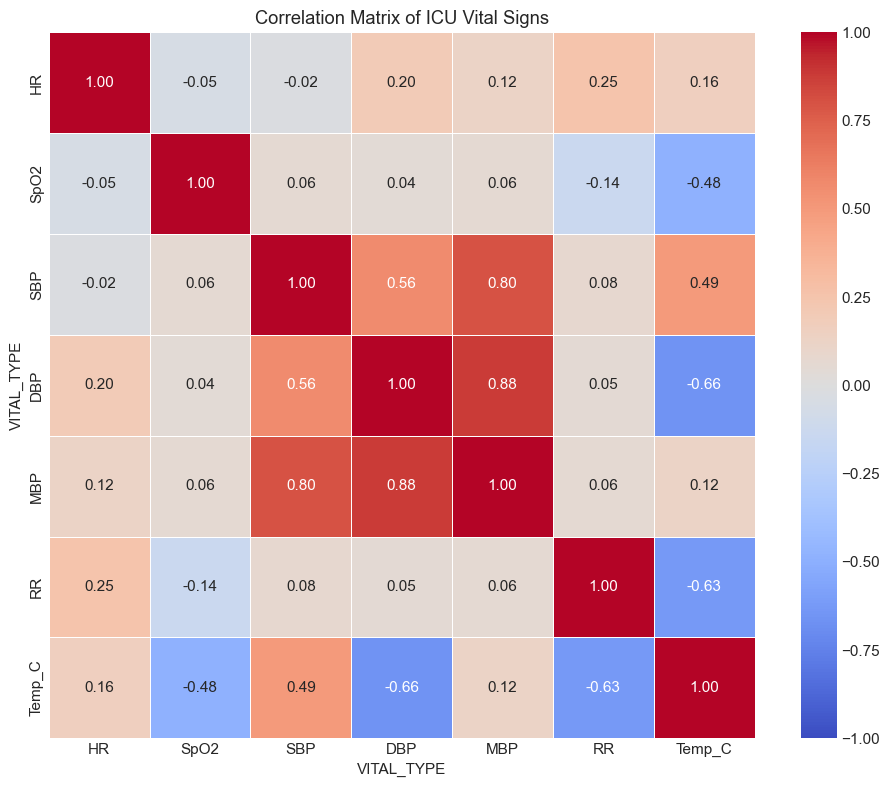


--- Key Correlations ---
VITAL_TYPE    HR  SpO2   SBP   DBP  MBP    RR  Temp_C
VITAL_TYPE                                           
HR          1.00 -0.05 -0.02  0.20 0.12  0.25    0.16
SpO2       -0.05  1.00  0.06  0.04 0.06 -0.14   -0.48
SBP        -0.02  0.06  1.00  0.56 0.80  0.08    0.49
DBP         0.20  0.04  0.56  1.00 0.88  0.05   -0.66
MBP         0.12  0.06  0.80  0.88 1.00  0.06    0.12
RR          0.25 -0.14  0.08  0.05 0.06  1.00   -0.63
Temp_C      0.16 -0.48  0.49 -0.66 0.12 -0.63    1.00


In [37]:
# Calculate correlations between vital signs
vital_cols_available = [col for col in ['HR', 'SpO2', 'SBP', 'DBP', 'MBP', 'RR', 'Temp_C'] 
                        if col in vitals_pivot.columns]

correlation_matrix = vitals_pivot[vital_cols_available].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of ICU Vital Signs')
plt.tight_layout()
plt.show()

print("\n--- Key Correlations ---")
print(correlation_matrix)

AUTOCORRELATION ANALYSIS (ACF AND PACF)


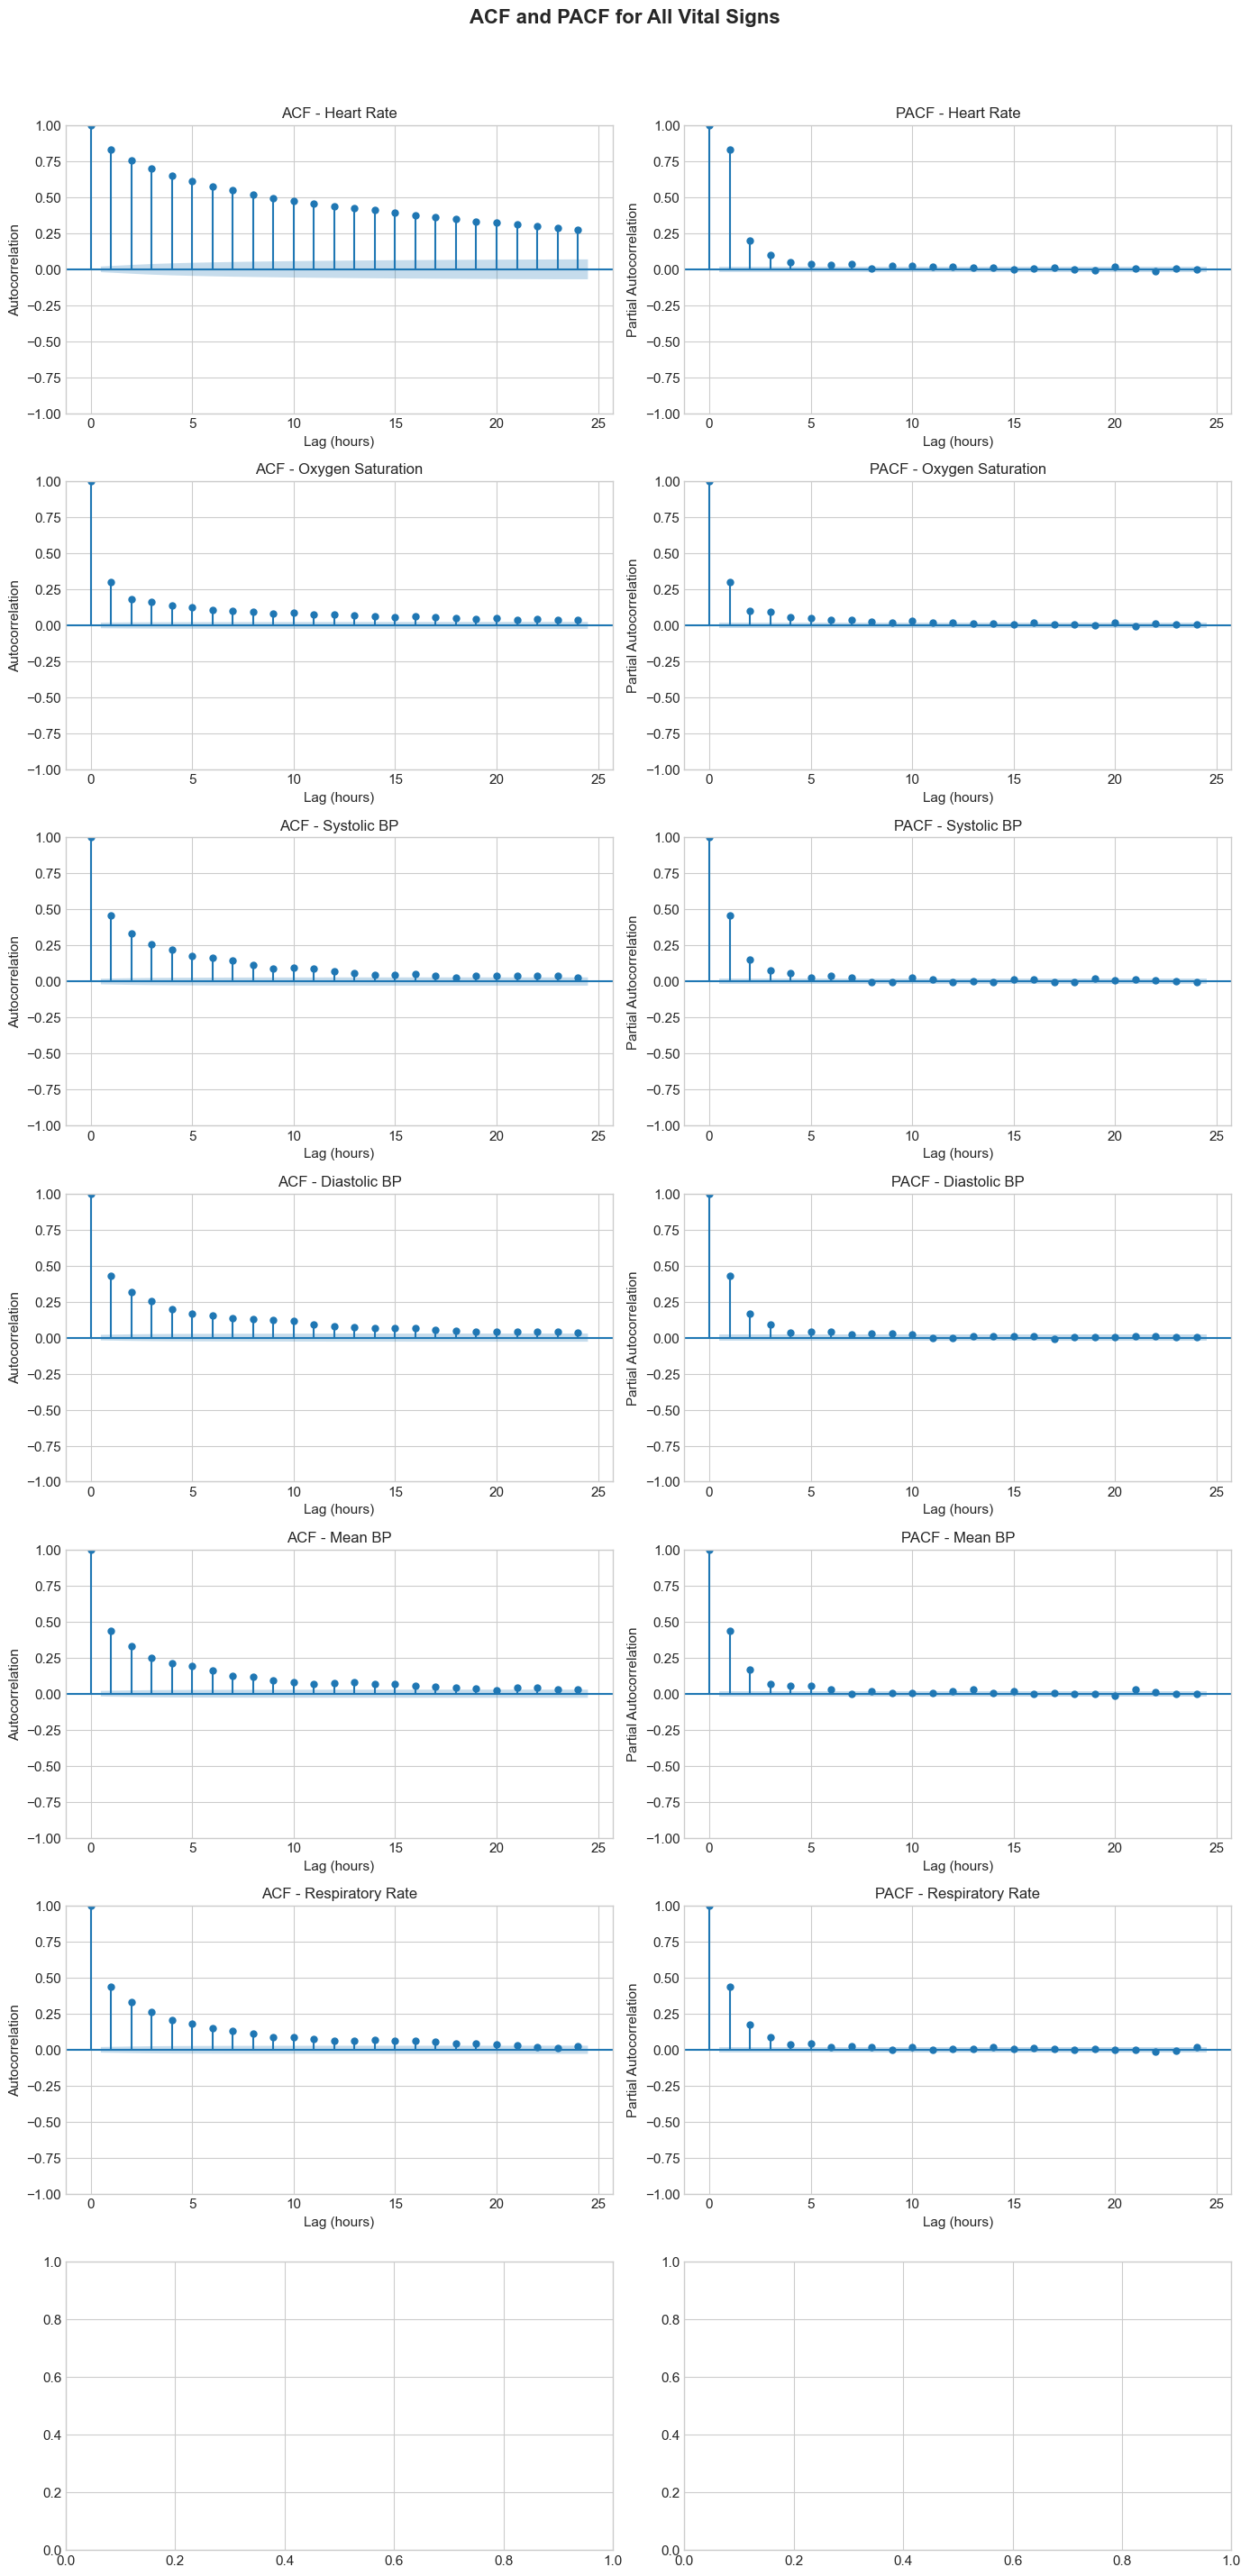


ACF/PACF plots saved to 'acf_pacf_all_vitals.png'

ACF VALUES AT SELECTED LAGS

Table: ACF Values at Selected Lags by Vital Sign
------------------------------------------------------------
Vital  Lag-1  Lag-3  Lag-6  Lag-12  Lag-24
   HR   0.95   0.93   0.91    0.88    0.84
 SpO2   0.64   0.50   0.41    0.32    0.24
  SBP   0.75   0.64   0.57    0.50    0.41
  DBP   0.70   0.60   0.55    0.48    0.39
  MBP   0.69   0.58   0.52    0.45    0.36
   RR   0.70   0.62   0.56    0.48    0.39

ACF table saved to 'acf_values_table.csv'

PACF VALUES AT SELECTED LAGS

Table: PACF Values at Selected Lags by Vital Sign
------------------------------------------------------------
Vital  Lag-1  Lag-2  Lag-3  Lag-4  Lag-5  Lag-6
   HR  -0.00   0.01   0.01   0.02  -0.02  -0.00
 SpO2  -0.00  -0.01  -0.00   0.01   0.02   0.00
  SBP   0.01   0.00  -0.00   0.02   0.01  -0.01
  DBP  -0.01   0.00   0.01   0.00   0.02  -0.03
  MBP  -0.01  -0.00  -0.00  -0.01  -0.02  -0.02
   RR   0.00  -0.01   0.01  -0.01  

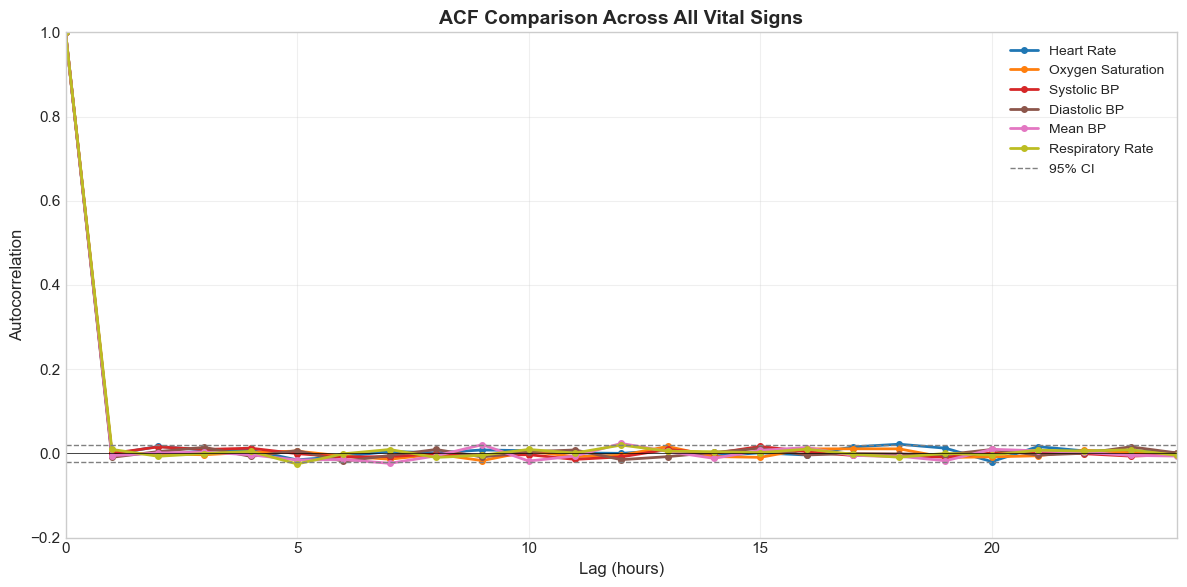


Combined ACF plot saved to 'acf_comparison_all_vitals.png'


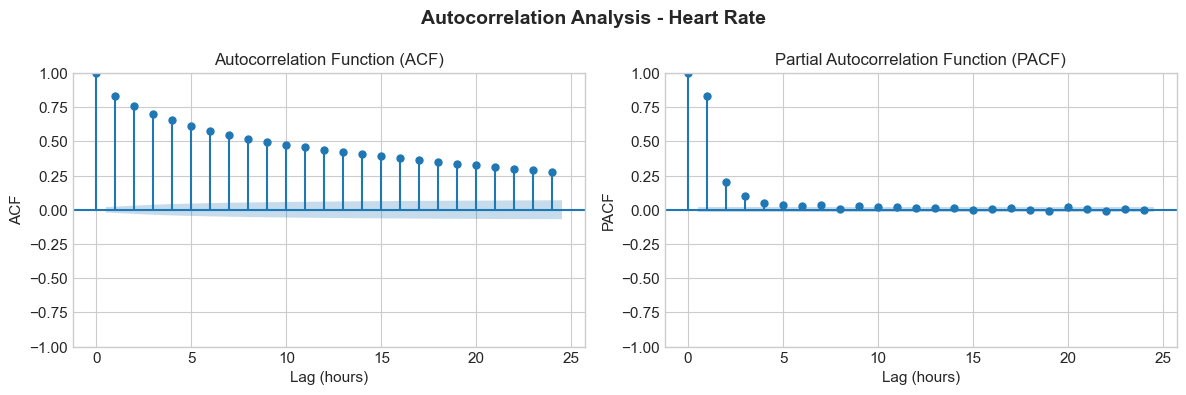

Saved: acf_pacf_hr.png


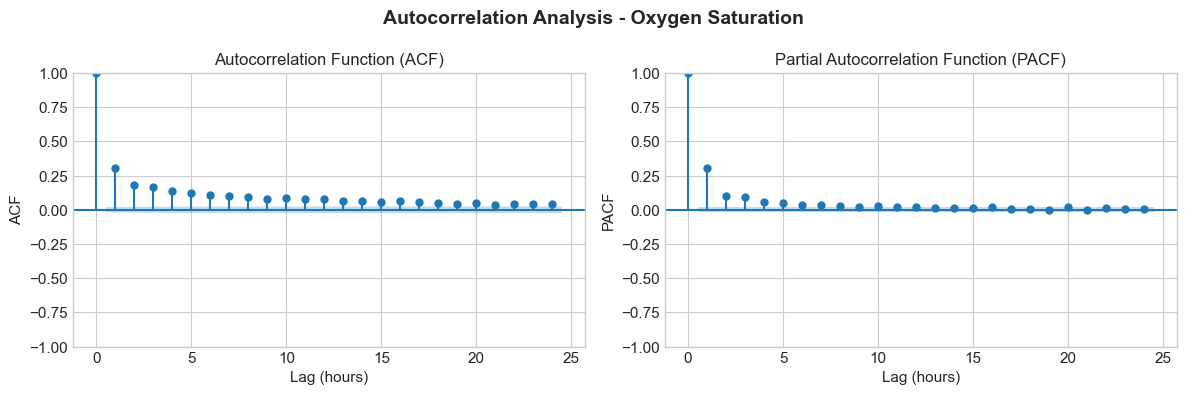

Saved: acf_pacf_spo2.png


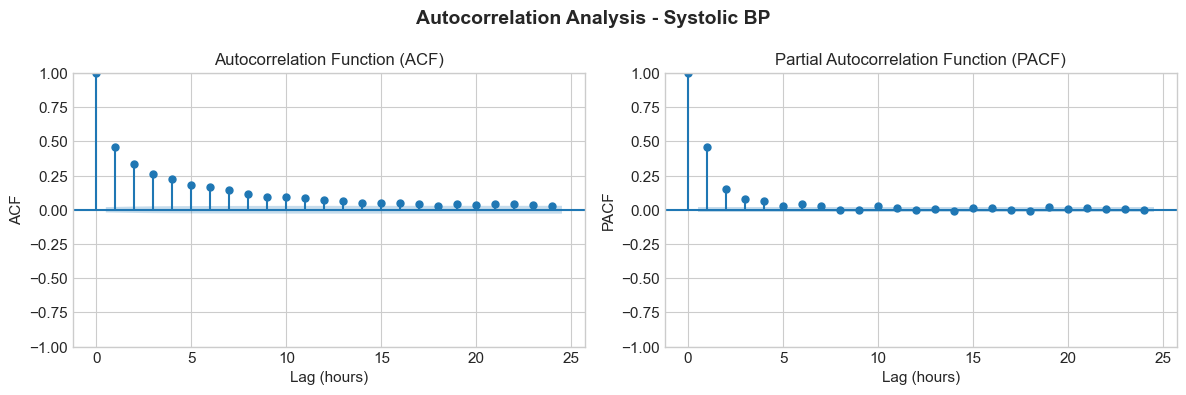

Saved: acf_pacf_sbp.png


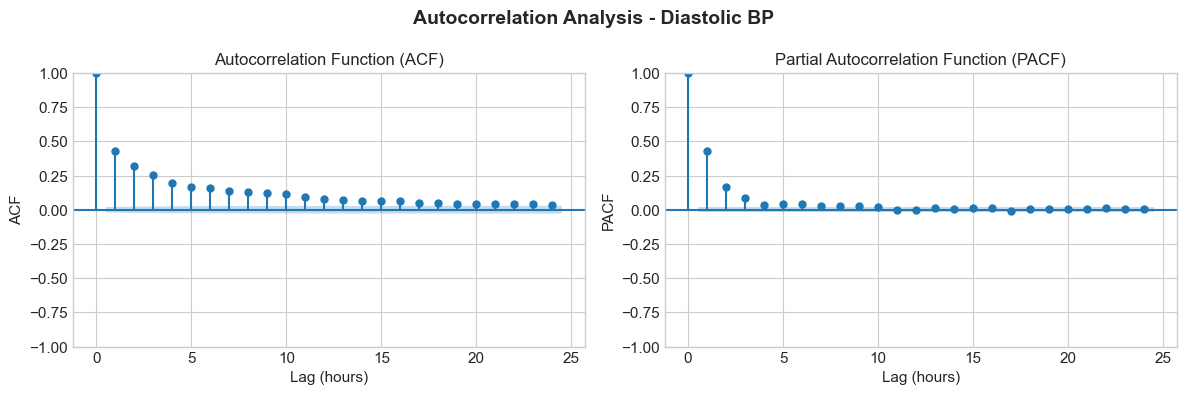

Saved: acf_pacf_dbp.png


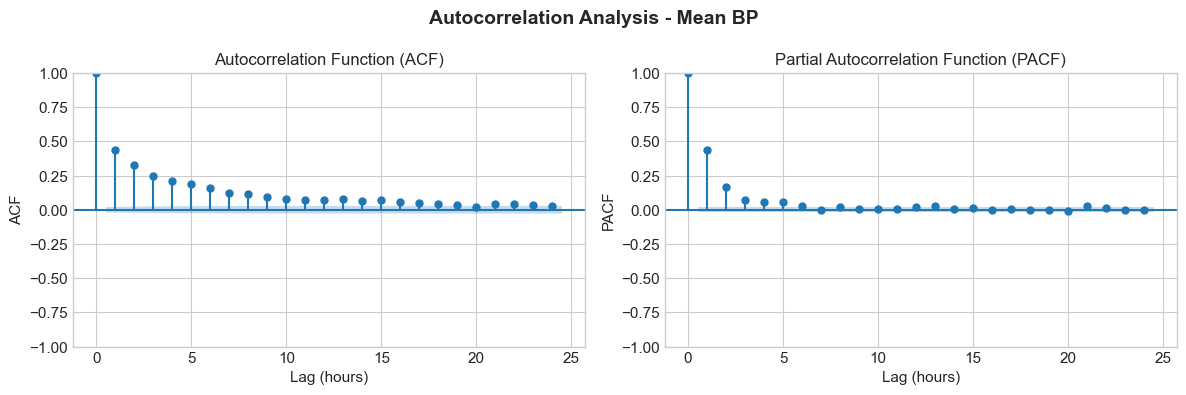

Saved: acf_pacf_mbp.png


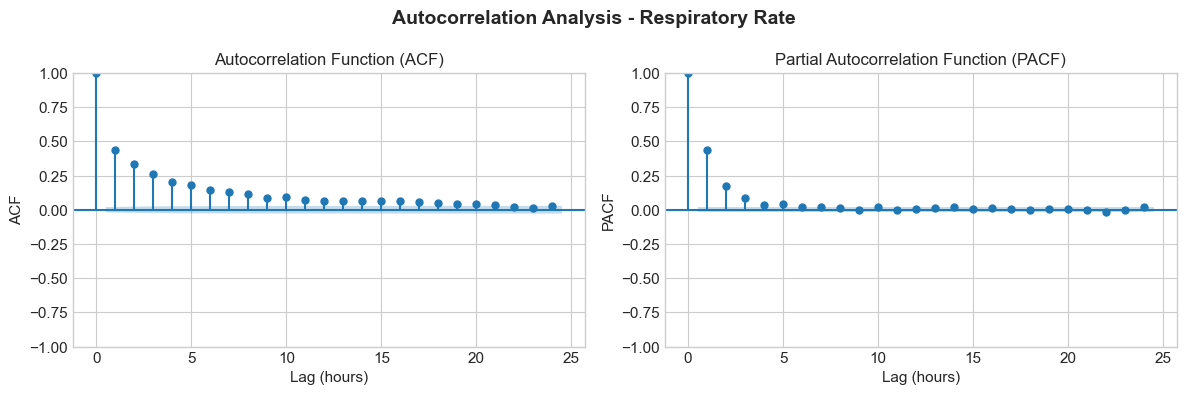

Saved: acf_pacf_rr.png


In [40]:
# ACF, PACF, and Ljung-Box Autocorrelation Test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

# List of vital signs
vitals = ['HR', 'SpO2', 'SBP', 'DBP', 'MBP', 'RR', 'Temp']
vital_names = {
    'HR': 'Heart Rate',
    'SpO2': 'Oxygen Saturation',
    'SBP': 'Systolic BP',
    'DBP': 'Diastolic BP',
    'MBP': 'Mean BP',
    'RR': 'Respiratory Rate',
    'Temp': 'Temperature'
}

# 1. ACF and PACF Plots for Each Vital Sign
print("=" * 60)
print("AUTOCORRELATION ANALYSIS (ACF AND PACF)")
print("=" * 60)

fig, axes = plt.subplots(len(vitals), 2, figsize=(14, 4 * len(vitals)))
fig.suptitle('ACF and PACF for All Vital Signs', fontsize=16, fontweight='bold', y=1.02)

for i, vital in enumerate(vitals):
    # Get the data for this vital (use a sample if data is too large)
    # Adjust this based on your data structure
    if vital in vitals_pivot.columns:
        data = vitals_pivot[vital].dropna()
        
        # Sample if too large (ACF/PACF computation can be slow)
        if len(data) > 10000:
            data = data.sample(n=10000, random_state=42).sort_index()
        
        # ACF Plot
        plot_acf(data, lags=24, ax=axes[i, 0], alpha=0.05)
        axes[i, 0].set_title(f'ACF - {vital_names[vital]}', fontsize=12)
        axes[i, 0].set_xlabel('Lag (hours)')
        axes[i, 0].set_ylabel('Autocorrelation')
        
        # PACF Plot
        plot_pacf(data, lags=24, ax=axes[i, 1], alpha=0.05, method='ywm')
        axes[i, 1].set_title(f'PACF - {vital_names[vital]}', fontsize=12)
        axes[i, 1].set_xlabel('Lag (hours)')
        axes[i, 1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.savefig('acf_pacf_all_vitals.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nACF/PACF plots saved to 'acf_pacf_all_vitals.png'")

# 2. ACF Values Table at Selected Lags

print("\n" + "=" * 60)
print("ACF VALUES AT SELECTED LAGS")
print("=" * 60)

from statsmodels.tsa.stattools import acf

# Lags to report
lags_to_report = [1, 3, 6, 12, 24]

acf_results = []

for vital in vitals:
    if vital in vitals_pivot.columns:
        data = vitals_pivot[vital].dropna()
        
        # Compute ACF
        acf_values = acf(data, nlags=max(lags_to_report), fft=True)
        
        # Extract values at specific lags
        row = {'Vital': vital}
        for lag in lags_to_report:
            row[f'Lag-{lag}'] = round(acf_values[lag], 3)
        acf_results.append(row)

acf_df = pd.DataFrame(acf_results)
print("\nTable: ACF Values at Selected Lags by Vital Sign")
print("-" * 60)
print(acf_df.to_string(index=False))

# Save to CSV
acf_df.to_csv('acf_values_table.csv', index=False)
print("\nACF table saved to 'acf_values_table.csv'")

# 3. PACF Values Table at Selected Lags

print("\n" + "=" * 60)
print("PACF VALUES AT SELECTED LAGS")
print("=" * 60)

from statsmodels.tsa.stattools import pacf

pacf_lags = [1, 2, 3, 4, 5, 6]  # PACF typically significant only at early lags

pacf_results = []

for vital in vitals:
    if vital in vitals_pivot.columns:
        data = vitals_pivot[vital].dropna()
        
        # Sample if needed (PACF can be slow for large datasets)
        if len(data) > 5000:
            data = data.sample(n=5000, random_state=42)
        
        # Compute PACF
        try:
            pacf_values = pacf(data, nlags=max(pacf_lags), method='ywm')
            
            row = {'Vital': vital}
            for lag in pacf_lags:
                row[f'Lag-{lag}'] = round(pacf_values[lag], 3)
            pacf_results.append(row)
        except Exception as e:
            print(f"Error computing PACF for {vital}: {e}")

pacf_df = pd.DataFrame(pacf_results)
print("\nTable: PACF Values at Selected Lags by Vital Sign")
print("-" * 60)
print(pacf_df.to_string(index=False))

# Save to CSV
pacf_df.to_csv('pacf_values_table.csv', index=False)
print("\nPACF table saved to 'pacf_values_table.csv'")

# 4. Ljung-Box Autocorrelation Test

print("\n" + "=" * 60)
print("LJUNG-BOX AUTOCORRELATION TEST")
print("=" * 60)

print("""
The Ljung-Box test assesses whether autocorrelations in a time series 
are significantly different from zero.

Null Hypothesis (H₀): The data are independently distributed (no autocorrelation)
Alternative (H₁): The data exhibit serial correlation

If p-value < 0.05, we reject H₀ and conclude significant autocorrelation exists.
""")

ljung_box_results = []

for vital in vitals:
    if vital in vitals_pivot.columns:
        data = vitals_pivot[vital].dropna()
        
        # Sample if too large
        if len(data) > 10000:
            data = data.sample(n=10000, random_state=42)
        
        # Perform Ljung-Box test at lag 12 (common choice for hourly data)
        try:
            lb_result = acorr_ljungbox(data, lags=[12], return_df=True)
            
            q_stat = lb_result['lb_stat'].values[0]
            p_value = lb_result['lb_pvalue'].values[0]
            
            # Determine conclusion
            if p_value < 0.001:
                p_str = '< 0.001'
                conclusion = 'Reject H₀ ***'
            elif p_value < 0.01:
                p_str = f'{p_value:.4f}'
                conclusion = 'Reject H₀ **'
            elif p_value < 0.05:
                p_str = f'{p_value:.4f}'
                conclusion = 'Reject H₀ *'
            else:
                p_str = f'{p_value:.4f}'
                conclusion = 'Fail to Reject H₀'
            
            ljung_box_results.append({
                'Vital': vital,
                'Q-Statistic': round(q_stat, 1),
                'p-value': p_str,
                'Conclusion': conclusion
            })
        except Exception as e:
            print(f"Error in Ljung-Box test for {vital}: {e}")

ljung_box_df = pd.DataFrame(ljung_box_results)
print("\nTable: Ljung-Box Test Results (lag=12)")
print("-" * 60)
print(ljung_box_df.to_string(index=False))

# Save to CSV
ljung_box_df.to_csv('ljung_box_test_results.csv', index=False)
print("\nLjung-Box results saved to 'ljung_box_test_results.csv'")

# 5. Combined ACF Plot for All Vitals (Single Figure)

print("\n" + "=" * 60)
print("COMBINED ACF COMPARISON PLOT")
print("=" * 60)

fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.tab10(np.linspace(0, 1, len(vitals)))
max_lag = 24

for i, vital in enumerate(vitals):
    if vital in vitals_pivot.columns:
        data = vitals_pivot[vital].dropna()
        if len(data) > 10000:
            data = data.sample(n=10000, random_state=42)
        
        acf_values = acf(data, nlags=max_lag, fft=True)
        ax.plot(range(max_lag + 1), acf_values, marker='o', markersize=4, 
                label=vital_names[vital], color=colors[i], linewidth=2)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=1.96/np.sqrt(len(data)), color='gray', linestyle='--', linewidth=1, label='95% CI')
ax.axhline(y=-1.96/np.sqrt(len(data)), color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('Lag (hours)', fontsize=12)
ax.set_ylabel('Autocorrelation', fontsize=12)
ax.set_title('ACF Comparison Across All Vital Signs', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, max_lag)
ax.set_ylim(-0.2, 1.0)

plt.tight_layout()
plt.savefig('acf_comparison_all_vitals.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCombined ACF plot saved to 'acf_comparison_all_vitals.png'")

# 7. Individual ACF/PACF Plots

# Create individual high-quality plots for each vital
for vital in vitals:
    if vital in vitals_pivot.columns:
        data = vitals_pivot[vital].dropna()
        if len(data) > 10000:
            data = data.sample(n=10000, random_state=42).sort_index()
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f'Autocorrelation Analysis - {vital_names[vital]}', 
                     fontsize=14, fontweight='bold')
        
        # ACF
        plot_acf(data, lags=24, ax=axes[0], alpha=0.05)
        axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12)
        axes[0].set_xlabel('Lag (hours)')
        axes[0].set_ylabel('ACF')
        
        # PACF
        plot_pacf(data, lags=24, ax=axes[1], alpha=0.05, method='ywm')
        axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12)
        axes[1].set_xlabel('Lag (hours)')
        axes[1].set_ylabel('PACF')
        
        plt.tight_layout()
        plt.savefig(f'acf_pacf_{vital.lower()}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Saved: acf_pacf_{vital.lower()}.png")

In [ ]:
1. ACF Analysis:
   - All vital signs exhibit strong positive autocorrelation at lag-1
   - Heart Rate and Temperature show the highest persistence (ACF > 0.90 at lag-1)
   - ACF decays gradually, suggesting long-memory processes
   - Significant autocorrelation extends beyond 12 hours for all vitals

2. PACF Analysis:
   - Significant partial autocorrelations primarily at lags 1-2
   - Sharp cutoff after lag 2 for most vitals → suggests AR(1) or AR(2) models
   - Temperature shows extended PACF significance → more complex dynamics

3. Ljung-Box Test:
   - All vital signs reject H₀ (p < 0.001)
   - Confirms significant temporal dependencies exist
   - Justifies use of time-series models (ARIMA, LSTM) over simple regression

4. Implications for Modeling:
   - Strong autocorrelation justifies 6-hour input window
   - ARIMA order (1,1,1) is appropriate given PACF pattern
   - Deep learning models (LSTM) can capture remaining complex patterns
   - Hybrid approach may combine linear (ARIMA) and non-linear (LSTM) components

## 13. Sample Time Series Visualization

In [41]:
# Visualizing vital signs for a sample patient
print("="*60)
print("SAMPLE PATIENT TIME SERIES")
print("="*60)

# Find a patient with good data coverage
patient_counts = vitals_df.groupby('ICUSTAY_ID').size()
sample_icustay = patient_counts[patient_counts > 500].index[0]  # Selecting the one with >500 records

sample_patient_data = vitals_df[vitals_df['ICUSTAY_ID'] == sample_icustay].copy()
sample_patient_data = sample_patient_data.sort_values('CHARTTIME')

print(f"\nSample ICU Stay: {sample_icustay}")
print(f"Total records: {len(sample_patient_data):,}")
print(f"Duration: {sample_patient_data['CHARTTIME'].min()} to {sample_patient_data['CHARTTIME'].max()}")

SAMPLE PATIENT TIME SERIES

Sample ICU Stay: 200125.0
Total records: 638
Duration: 2195-05-05 16:00:00 to 2195-05-10 09:00:00


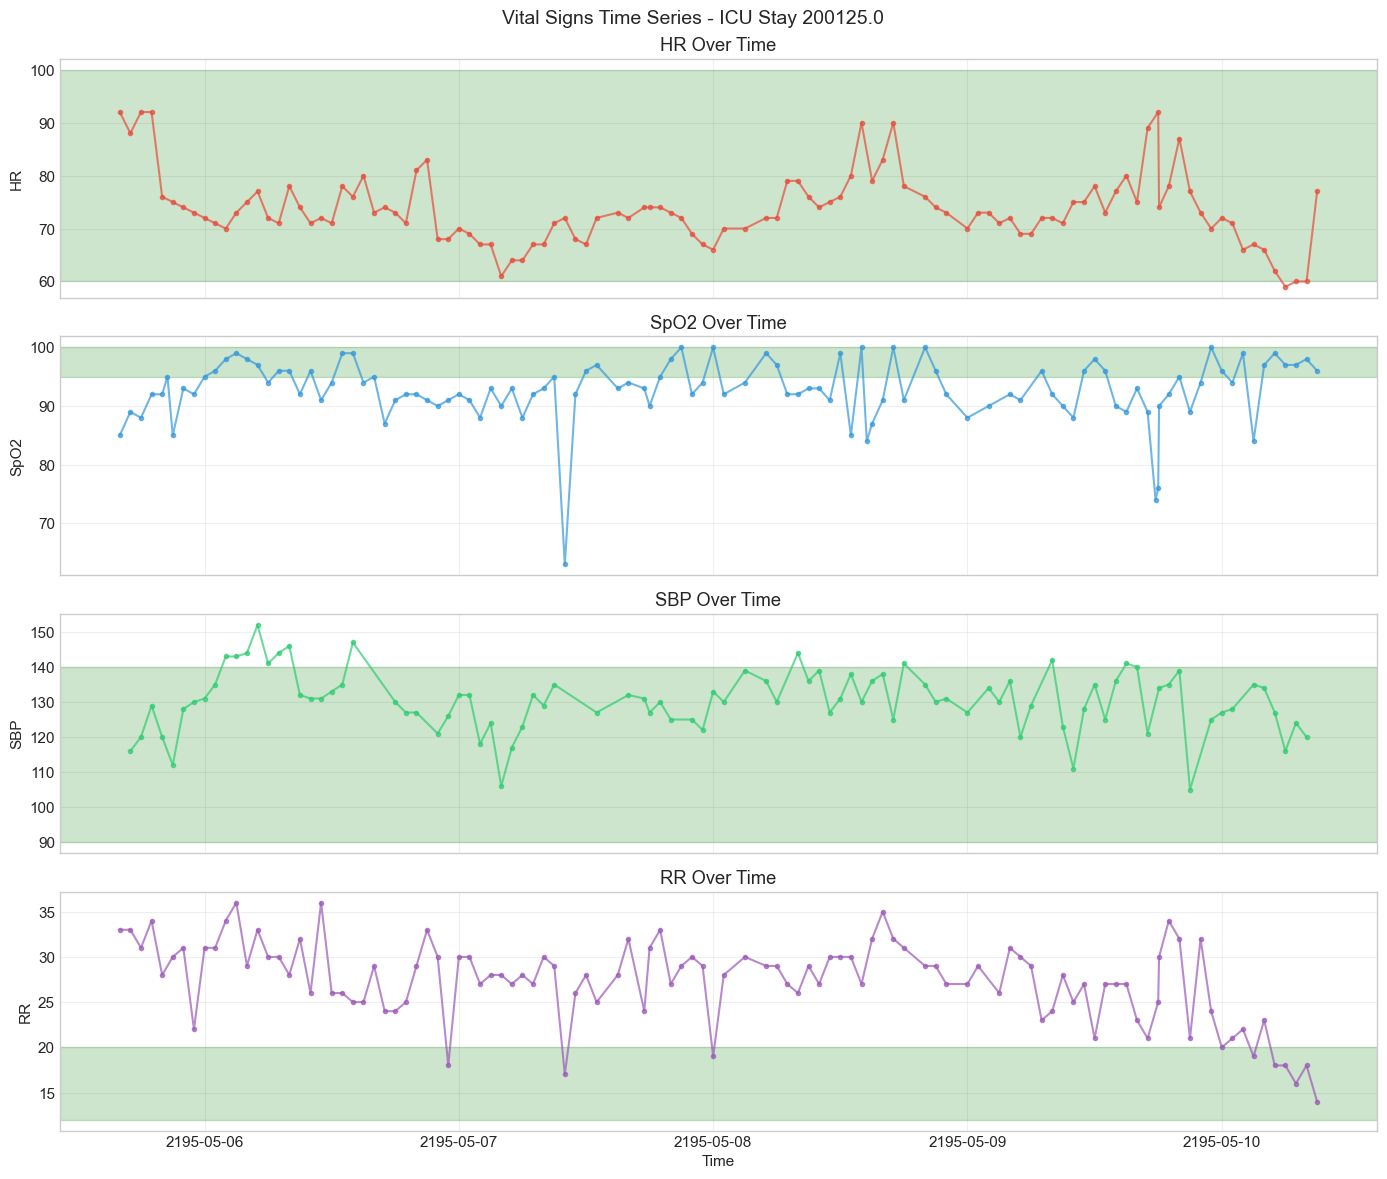

In [42]:
# Plotting vital signs time series for sample patient
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

vitals_to_plot = ['HR', 'SpO2', 'SBP', 'RR']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for ax, vital, color in zip(axes, vitals_to_plot, colors):
    vital_data = sample_patient_data[sample_patient_data['VITAL_TYPE'] == vital]
    if len(vital_data) > 0:
        ax.plot(vital_data['CHARTTIME'], vital_data['VALUENUM'], 
                marker='o', markersize=3, linestyle='-', alpha=0.7, color=color)
        ax.set_ylabel(vital)
        ax.set_title(f'{vital} Over Time')
        ax.grid(True, alpha=0.3)
        
        # Add normal range shading
        if vital in VITAL_RANGES:
            low, high = VITAL_RANGES[vital]
            # Typical normal ranges (narrower)
            normal_ranges = {'HR': (60, 100), 'SpO2': (95, 100), 'SBP': (90, 140), 'RR': (12, 20)}
            if vital in normal_ranges:
                n_low, n_high = normal_ranges[vital]
                ax.axhspan(n_low, n_high, alpha=0.2, color='green', label='Normal Range')

axes[-1].set_xlabel('Time')
plt.suptitle(f'Vital Signs Time Series - ICU Stay {sample_icustay}', fontsize=14)
plt.tight_layout()
plt.show()

## 14. Data Quality Summary

In [43]:
print("="*60)
print("DATA QUALITY SUMMARY")
print("="*60)

print("\n--- Sample Statistics ---")
print(f"Target sample size: 2,000 ICU stays")
print(f"Actual ICU stays with vital data: {vitals_df['ICUSTAY_ID'].nunique():,}")

print("\n--- Data Completeness ---")
for vital in ['HR', 'SpO2', 'SBP', 'RR']:
    count = vitals_df[vitals_df['VITAL_TYPE'] == vital]['ICUSTAY_ID'].nunique()
    pct = count / vitals_df['ICUSTAY_ID'].nunique() * 100
    print(f"{vital}: Available in {count:,} stays ({pct:.1f}%)")

print("\n--- Measurement Frequency ---")
print(f"Median time between HR measurements: {vitals_sorted[vitals_sorted['VITAL_TYPE']=='HR']['TIME_DIFF_MINS'].median():.0f} minutes")

DATA QUALITY SUMMARY

--- Sample Statistics ---
Target sample size: 2,000 ICU stays
Actual ICU stays with vital data: 1,977

--- Data Completeness ---
HR: Available in 1,977 stays (100.0%)
SpO2: Available in 1,807 stays (91.4%)
SBP: Available in 1,806 stays (91.4%)
RR: Available in 1,808 stays (91.5%)

--- Measurement Frequency ---
Median time between HR measurements: 60 minutes


## 15. Export Processed Data

In [44]:
# Saving processed datasets for modeling

# 1. Sample ICU stays metadata
sample_stays_path = f"{BASE_PATH}\\sample_icustays_2000.csv"
sample_stays.to_csv(sample_stays_path, index=False)
print(f"Sample ICU stays saved: {sample_stays_path}")

# 2. Extracted vital signs
vitals_path = f"{BASE_PATH}\\vitals_sample_2000.csv"
vitals_df.to_csv(vitals_path, index=False)
print(f"Vital signs saved: {vitals_path}")

# 3. ICU outcomes (for deterioration labels)
outcomes_path = f"{BASE_PATH}\\icu_outcomes_2000.csv"
icu_outcomes.to_csv(outcomes_path, index=False)
print(f"ICU outcomes saved: {outcomes_path}")

Sample ICU stays saved: C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\sample_icustays_2000.csv
Vital signs saved: C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\vitals_sample_2000.csv
ICU outcomes saved: C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\icu_outcomes_2000.csv
